# League-Wide PPS Analysis (2024-25 Season)

This notebook analyzes **Points Per Shot (PPS)** across all 30 NBA teams from last season.

## What is PPS?
- **Formula:** Total Points / Total Shots
- **Range:** 0 (all misses) to 3.0 (100% on 3-pointers)
- **Why it matters:** Combines accuracy and shot value into one efficiency metric

## Analysis
- Fetch shot data for all 30 NBA teams
- Calculate league-wide PPS by zone
- Identify which zones generate the most value per attempt across the NBA

In [12]:
# Setup - Import libraries and configure
import sys
from pathlib import Path

# Add parent directory to path so we can import bulls
sys.path.insert(0, str(Path().absolute().parent))

from bulls import data, analysis, viz
from bulls.config import LAST_SEASON
import pandas as pd
import matplotlib.pyplot as plt

# Configure matplotlib for better display in notebooks
plt.style.use('default')
%matplotlib inline

print("Bulls Analytics loaded")
print(f"Season: {LAST_SEASON}")

Bulls Analytics loaded
Season: 2024-25


## Step 1: Fetch League-Wide Shot Data

Fetch shot data for all 30 NBA teams. This takes several minutes due to API rate limiting (~18 seconds per team).

In [13]:
# Fetch shot data for all 30 NBA teams from 2024-25 season
print(f"Fetching league-wide shot data for {LAST_SEASON}...")
print("This may take several minutes due to NBA API rate limits.\n")

league_shots = data.get_league_shots(season=LAST_SEASON)

if league_shots.empty:
    print("No shot data available")
else:
    print(f"\nLoaded {len(league_shots):,} shots from {league_shots['team_abbr'].nunique()} teams")

Fetching league-wide shot data for 2024-25...
This may take several minutes due to NBA API rate limits.

[1/30] Fetching Atlanta Hawks...
    -> 7,528 shots
[2/30] Fetching Boston Celtics...
    -> 7,382 shots
[3/30] Fetching Brooklyn Nets...
    -> 7,060 shots
[4/30] Fetching Charlotte Hornets...
    -> 7,308 shots
[5/30] Fetching Chicago Bulls...
    -> 7,545 shots
[6/30] Fetching Cleveland Cavaliers...
    -> 7,444 shots
[7/30] Fetching Dallas Mavericks...
    -> 7,194 shots
[8/30] Fetching Denver Nuggets...
    -> 7,360 shots
[9/30] Fetching Detroit Pistons...
    -> 7,363 shots
[10/30] Fetching Golden State Warriors...
    -> 7,412 shots
[11/30] Fetching Houston Rockets...
    -> 7,659 shots
[12/30] Fetching Indiana Pacers...
    -> 7,326 shots
[13/30] Fetching LA Clippers...
    -> 7,075 shots
[14/30] Fetching Los Angeles Lakers...
    -> 7,007 shots
[15/30] Fetching Memphis Grizzlies...
    -> 7,654 shots
[16/30] Fetching Miami Heat...
    -> 7,138 shots
[17/30] Fetching Milwauk

## Step 2: League PPS by Zone

Calculate the league-wide points per shot for each zone. This shows which areas on the court yield the highest expected value per shot attempt across all NBA teams.

In [14]:
# Calculate league-wide PPS by zone
league_pps = analysis.league_pps_by_zone(league_shots)

# Display league overall stats
print(f"=== NBA League-Wide PPS ({LAST_SEASON}) ===")
print(f"Total Shots:     {league_pps['league_overall']['total_shots']:,}")
print(f"Total Points:    {league_pps['league_overall']['total_points']:,}")
print(f"League PPS:      {league_pps['league_overall']['pps']:.3f}")
print(f"League FG%:      {league_pps['league_overall']['fg_pct']:.1f}%")

# Display zone rankings
print("\n=== PPS by Zone (Ranked by Value) ===")
zone_rankings = analysis.zone_value_ranking(league_pps)
print(zone_rankings.to_string(index=False))

=== NBA League-Wide PPS (2024-25) ===
Total Shots:     219,527
Total Points:    238,436
League PPS:      1.086
League FG%:      46.7%

=== PPS by Zone (Ranked by Value) ===
                 Zone   PPS  FG%  Points  Shots  Volume%  Rank
      Restricted Area 1.327 66.4   81206  61190     27.9     1
       Right Corner 3 1.170 39.0   13329  11397      5.2     2
        Left Corner 3 1.158 38.6   14118  12188      5.6     3
    Above the Break 3 1.060 35.3   72427  68358     31.1     4
In The Paint (Non-RA) 0.887 44.4   39468  44475     20.3     5
            Mid-Range 0.834 41.7   17852  21402      9.7     6
            Backcourt 0.070  2.3      36    517      0.2     7


## Step 3: Visualize League Zone Value

A bar chart showing the value (PPS) of each shot zone across the entire NBA.

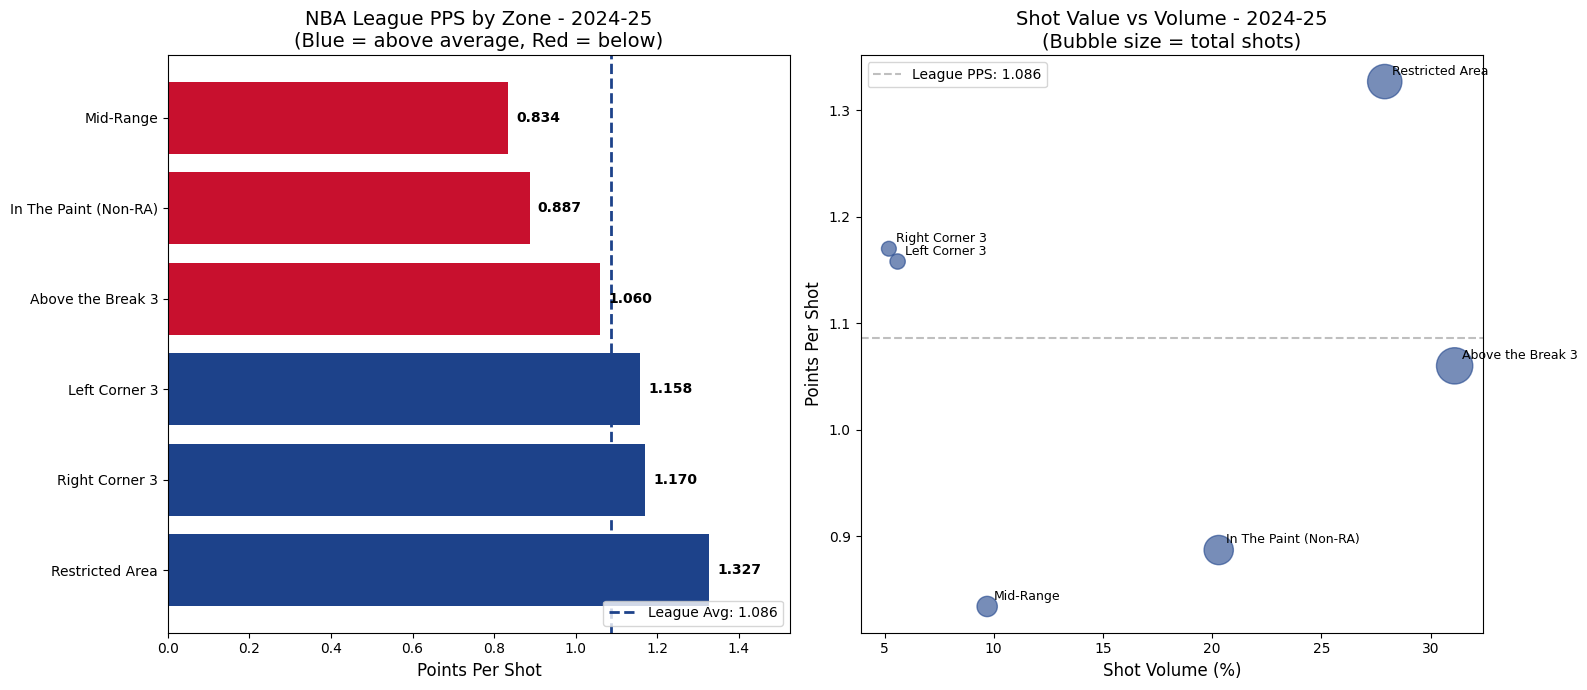

In [15]:
# Visualize league PPS by zone
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Filter out Backcourt (rare shots, skews visualization)
zone_df_filtered = zone_rankings[zone_rankings['Zone'] != 'Backcourt'].copy()

# Left plot: PPS by Zone
ax1 = axes[0]
colors = ['#1d428a' if pps > league_pps['league_overall']['pps'] else '#c8102e' 
          for pps in zone_df_filtered['PPS']]

bars = ax1.barh(zone_df_filtered['Zone'], zone_df_filtered['PPS'], color=colors)
ax1.axvline(x=league_pps['league_overall']['pps'], color='#1d428a', linestyle='--', 
            linewidth=2, label=f"League Avg: {league_pps['league_overall']['pps']:.3f}")

for bar, row in zip(bars, zone_df_filtered.itertuples()):
    ax1.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
             f"{row.PPS:.3f}", va='center', fontsize=10, fontweight='bold')

ax1.set_xlabel('Points Per Shot', fontsize=12)
ax1.set_title(f'NBA League PPS by Zone - {LAST_SEASON}\n(Blue = above average, Red = below)', fontsize=14)
ax1.legend(loc='lower right')
ax1.set_xlim(0, max(zone_df_filtered['PPS']) * 1.15)

# Right plot: Shot Volume vs PPS (bubble chart)
ax2 = axes[1]
scatter = ax2.scatter(zone_df_filtered['Volume%'], zone_df_filtered['PPS'], 
                      s=zone_df_filtered['Shots']/100, c='#1d428a', alpha=0.6)

for _, row in zone_df_filtered.iterrows():
    ax2.annotate(row['Zone'], (row['Volume%'], row['PPS']),
                 xytext=(5, 5), textcoords='offset points', fontsize=9)

ax2.axhline(y=league_pps['league_overall']['pps'], color='gray', linestyle='--', 
            alpha=0.5, label=f"League PPS: {league_pps['league_overall']['pps']:.3f}")

ax2.set_xlabel('Shot Volume (%)', fontsize=12)
ax2.set_ylabel('Points Per Shot', fontsize=12)
ax2.set_title(f'Shot Value vs Volume - {LAST_SEASON}\n(Bubble size = total shots)', fontsize=14)
ax2.legend()

plt.tight_layout()
plt.show()

## Key Insights

**Which shots yield the most value?**

Based on the NBA-wide analysis:

1. **Restricted Area** - Highest volume AND high efficiency. This is why teams prioritize paint touches.

2. **Corner 3s** - The most efficient 3-point shot. Shorter distance + no sideline defenders = better percentages.

3. **Above the Break 3** - High volume due to ball movement patterns, but typically lower efficiency than corners.

4. **Mid-Range** - Lowest value per shot. The "no man's land" of basketball - too far for 2PT efficiency, worth less than 3PT.

5. **In The Paint (Non-RA)** - Floaters and short jumpers. Contested shots with only 2-point value.

**The Modern NBA Formula:** 
Maximize shots at the rim + take corner 3s > above-the-break 3s > avoid mid-range

**Caveat:** Elite mid-range shooters (like Durant, DeRozan) can make mid-range shots valuable through volume and clutch situations.

---

## Bulls vs League Average

Compare the Chicago Bulls' current season (2025-26) zone efficiency against the league averages calculated above.

In [16]:
# Fetch Bulls current season shot data
from bulls.config import CURRENT_SEASON

print(f"Fetching Bulls shot data for {CURRENT_SEASON}...")
bulls_shots = data.get_team_shots(season=CURRENT_SEASON)

if bulls_shots.empty:
    print("No Bulls shot data available")
else:
    print(f"Loaded {len(bulls_shots):,} Bulls shots from {bulls_shots['game_id'].nunique()} games")

Fetching Bulls shot data for 2025-26...
Loaded 3,815 Bulls shots from 42 games


In [17]:
# Calculate Bulls PPS by zone
bulls_pps = analysis.points_per_shot(bulls_shots, by_zone=True)

# Build comparison DataFrame
comparison_data = []
for zone, bulls_stats in bulls_pps['by_zone'].items():
    league_stats = league_pps['by_zone'].get(zone, {})
    league_zone_pps = league_stats.get('pps', 0)
    
    comparison_data.append({
        'Zone': zone,
        'Bulls PPS': bulls_stats['pps'],
        'League PPS': league_zone_pps,
        'Diff': bulls_stats['pps'] - league_zone_pps,
        'Bulls Shots': bulls_stats['total_shots']
    })

comparison_df = pd.DataFrame(comparison_data).sort_values('Bulls Shots', ascending=False)
comparison_df = comparison_df.reset_index(drop=True)

print(f"=== Bulls ({CURRENT_SEASON}) vs League Average ({LAST_SEASON}) ===")
print(comparison_df.to_string(index=False))

# Overall comparison
print(f"\n=== Overall ===")
print(f"Bulls PPS:  {bulls_pps['overall']['pps']:.3f}")
print(f"League PPS: {league_pps['league_overall']['pps']:.3f}")
diff = bulls_pps['overall']['pps'] - league_pps['league_overall']['pps']
print(f"Difference: {diff:+.3f} ({'above' if diff > 0 else 'below'} league average)")

=== Bulls (2025-26) vs League Average (2024-25) ===
                 Zone  Bulls PPS  League PPS   Diff  Bulls Shots
      Restricted Area      1.268       1.327 -0.059         1356
    Above the Break 3      1.033       1.060 -0.027         1194
In The Paint (Non-RA)      0.906       0.887  0.019          638
        Left Corner 3      1.097       1.158 -0.061          238
       Right Corner 3      1.312       1.170  0.142          215
            Mid-Range      0.786       0.834 -0.048          173
            Backcourt      3.000       0.070  2.930            1

=== Overall ===
Bulls PPS:  1.104
League PPS: 1.086
Difference: +0.018 (above league average)


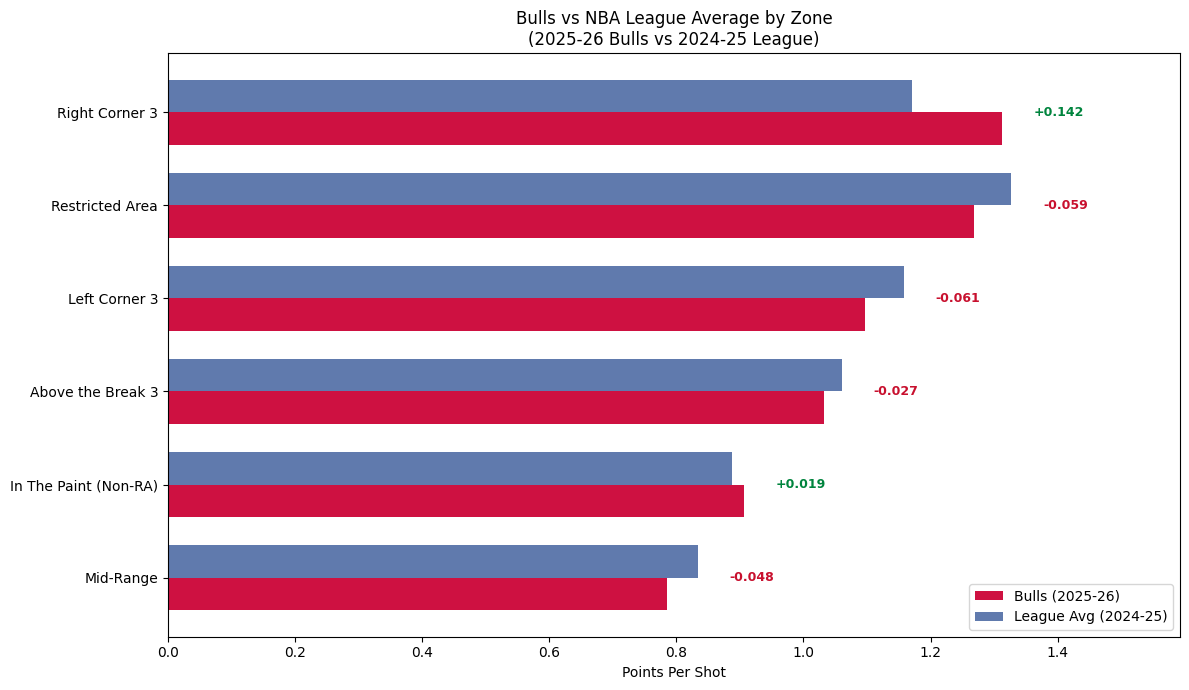

In [18]:
# Visualize Bulls vs League by zone
fig, ax = plt.subplots(figsize=(12, 7))

# Filter out Backcourt (too few shots)
viz_df = comparison_df[comparison_df['Zone'] != 'Backcourt'].copy()
viz_df = viz_df.sort_values('Bulls PPS', ascending=True)

y_pos = range(len(viz_df))
width = 0.35

# Create grouped bars
bars1 = ax.barh([y - width/2 for y in y_pos], viz_df['Bulls PPS'], width, 
                label=f'Bulls ({CURRENT_SEASON})', color='#CE1141')
bars2 = ax.barh([y + width/2 for y in y_pos], viz_df['League PPS'], width, 
                label=f'League Avg ({LAST_SEASON})', color='#1d428a', alpha=0.7)

ax.set_yticks(y_pos)
ax.set_yticklabels(viz_df['Zone'])
ax.set_xlabel('Points Per Shot')
ax.set_title(f'Bulls vs NBA League Average by Zone\n({CURRENT_SEASON} Bulls vs {LAST_SEASON} League)')
ax.legend(loc='lower right')

# Add difference annotations
for i, (_, row) in enumerate(viz_df.iterrows()):
    diff = row['Diff']
    color = '#00843d' if diff > 0 else '#c8102e'
    ax.annotate(f"{diff:+.3f}", 
                xy=(max(row['Bulls PPS'], row['League PPS']) + 0.05, i),
                va='center', fontsize=9, color=color, fontweight='bold')

ax.set_xlim(0, max(viz_df['Bulls PPS'].max(), viz_df['League PPS'].max()) * 1.2)

plt.tight_layout()
plt.show()

### Bulls Comparison Insights

- **Green** differences indicate zones where the Bulls exceed the league average
- **Red** differences highlight areas for improvement
- Compare high-volume zones (Restricted Area, Above the Break 3) to see where efficiency gains matter most

## Step 4: League-Wide PPS vs FG% by Zone

Compare Points Per Shot (PPS) against Field Goal Percentage (FG%) across all NBA teams to identify which zones provide the best balance of efficiency and accuracy league-wide. Zones in the upper-right quadrant represent high-value shot locations (both accurate and efficient).

In [ ]:
# Scatter plot: League PPS vs FG% by Zone
fig, ax = plt.subplots(figsize=(12, 8))

# Extract PPS and FG% for each zone from league data
fg_pct_values = []
pps_values = []
zone_names = []

for zone, stats in league_pps['by_zone'].items():
    if zone != 'Backcourt':  # Filter out Backcourt (rare shots)
        zone_names.append(zone)
        fg_pct_values.append(stats['fg_pct'])
        pps_values.append(stats['pps'])

# Create scatter plot
scatter = ax.scatter(fg_pct_values, pps_values, 
                     s=200, c='#1d428a', alpha=0.7, edgecolors='black', linewidth=1.5)

# Add zone labels
for i, zone in enumerate(zone_names):
    ax.annotate(zone, (fg_pct_values[i], pps_values[i]),
                xytext=(5, 5), textcoords='offset points', fontsize=9, fontweight='bold')

# Add reference lines for league averages
league_avg_fg = league_pps['league_overall']['fg_pct']
league_avg_pps = league_pps['league_overall']['pps']

ax.axhline(y=league_avg_pps, color='gray', linestyle='--', 
           alpha=0.5, linewidth=2, label=f"League Avg PPS: {league_avg_pps:.3f}")
ax.axvline(x=league_avg_fg, color='gray', linestyle='--', 
           alpha=0.5, linewidth=2, label=f"League Avg FG%: {league_avg_fg:.1f}%")

ax.set_xlabel('Field Goal Percentage (%)', fontsize=12, fontweight='bold')
ax.set_ylabel('Points Per Shot', fontsize=12, fontweight='bold')
ax.set_title(f'NBA League PPS vs FG% by Zone - {LAST_SEASON}\n(Upper-right = High Value Zones)', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(loc='lower left')

plt.tight_layout()
plt.show()